In [1]:
from __future__ import print_function, division, absolute_import

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [42]:
import os, sys, warnings
import ntpath

import tarfile

import imageio

from collections import deque
from joblib import Parallel, delayed

import numpy as np

from IPython.display import display, Image

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics.classification import accuracy_score

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline 

### Downloading the data

In [4]:
url = 'https://commondatastorage.googleapis.com/books1000/'
data_root = 'data'
last_percent = None
def download_progress(count, block_size, total_size):
    global last_percent
    percent = count*block_size*100 // total_size
    if last_percent != percent:
        if percent %5 == 0:
            sys.stdout.write("%s%%"%percent)
            sys.stdout.flush()
        else:
            sys.stdout.write("~")
            sys.stdout.flush()
    last_percent = percent

def maybe_download(filename, force=False):
    if not os.path.exists(data_root):
        os.mkdir(data_root)
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print("Downloading:", filename)
        filename, _ = urlretrieve(url+filename, dest_filename, reporthook=download_progress)
        print("\nDownload complete!")
    return os.path.join(data_root, filename)

In [5]:
def maybe_extract(filename, force=False):
    filename_raw = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    print(filename_raw)
    if os.path.isdir(filename_raw) and not force:
        print("{0} exists, Skipping extraction.".format(filename_raw))
    else:
        # data_root = os.path.dirname(os.path.splitext(os.path.splitext(test_filename)[0])[0])
        with tarfile.open(filename) as tar:
            tar.extractall(data_root)
    data_folders = [os.path.join(filename_raw, d) for d in sorted(os.listdir(filename_raw))
    if os.path.isdir(os.path.join(filename_raw, d))]
    return data_folders

In [6]:
train_filename = maybe_download("notMNIST_large.tar.gz",)
test_filename = maybe_download("notMNIST_small.tar.gz")

Downloading: notMNIST_large.tar.gz
0%~~~~5%~~~~10%~~~~15%~~~~20%~~~~25%~~~~30%~~~~35%~~~~40%~~~~45%~~~~50%~~~~55%~~~~60%~~~~65%~~~~70%~~~~75%~~~~80%~~~~85%~~~~90%~~~~95%~~~~100%
Download complete!
Downloading: notMNIST_small.tar.gz
0%~~~~5%~~~~10%~~~~15%~~~~20%~~~~25%~~~~30%~~~~35%~~~~40%~~~~45%~~~~50%~~~~55%~~~~60%~~~~65%~~~~70%~~~~75%~~~~80%~~~~85%~~~~90%~~~~95%~~~~100%
Download complete!


In [7]:
train_filename, test_filename

('data/notMNIST_large.tar.gz', 'data/notMNIST_small.tar.gz')

In [8]:
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
train_folders, test_folders

data/notMNIST_large
data/notMNIST_large exists, Skipping extraction.
data/notMNIST_small
data/notMNIST_small exists, Skipping extraction.


(['data/notMNIST_large/A',
  'data/notMNIST_large/B',
  'data/notMNIST_large/C',
  'data/notMNIST_large/D',
  'data/notMNIST_large/E',
  'data/notMNIST_large/F',
  'data/notMNIST_large/G',
  'data/notMNIST_large/H',
  'data/notMNIST_large/I',
  'data/notMNIST_large/J'],
 ['data/notMNIST_small/A',
  'data/notMNIST_small/B',
  'data/notMNIST_small/C',
  'data/notMNIST_small/D',
  'data/notMNIST_small/E',
  'data/notMNIST_small/F',
  'data/notMNIST_small/G',
  'data/notMNIST_small/H',
  'data/notMNIST_small/I',
  'data/notMNIST_small/J'])

In [15]:
letters="ABCDEFGHIJ"
for l in letters:
    img_path = os.path.join(data_root, "notMNIST_small", l)
    img_name = np.random.choice(os.listdir(img_path))
    display(Image(filename=os.path.join(img_path,img_name)))

### Image2Tensors

In [10]:
image_size = 28
pixel_depth = 255

In [11]:
def get_image_data(folder, image_name, normalization_factor):
    image_file = os.path.join(folder,image_name)
    normalizer = lambda x, normalization_factor: (x-normalization_factor)/normalization_factor
    try:
        image_data_raw = imageio.imread(image_file)
    except Exception as e:
        print("ERROR READING {}".format(image_file),e)
        return "<INVALID>"
    image_data = normalizer(image_data_raw, normalization_factor)
    if image_data.shape != (image_size, image_size):
        warnings.warn("Unexpected image shape: {}".format(image_data.shape))
        return "<INVALID>"
    else:
        return image_data


def load_letter(folder, min_num_images, parallel=True):
    """Loading the data for a single letter label"""
    image_files = os.listdir(folder)
    normalization_factor = (pixel_depth+1)//2
    print(folder)
    if parallel:
        images = Parallel(n_jobs=-1)(delayed(get_image_data)(
            folder, image_name, normalization_factor)for image_name in image_files)
        images = [i for i in images if type(i)!=str]
    else:
        images = deque(maxlen=len(image_files))
        normalize = lambda x, normalization_factor: (x-normalization_factor)/normalization_factor
        for image_name in image_files:
            image_file = os.path.join(folder,image_name)
            try:
                image_data_raw = imageio.imread(image_file)
            except Exception as e:
                print("Couldn't read {}".format(image_file), e)
                continue
            image_data = normalize(image_data_raw, normalization_factor)
            if image_data.shape != (image_size, image_size):
                warnings.warn("Unexpected image shape: {}".format(image_data.shape))
                continue
            else:
                images.append(image_data)
    
    if len(images)<min_num_images:
        raise Exception("Minimum number of instances is {0}. Got {1} instead.".format(min_num_images, len(images)))
    dataset = np.ndarray(shape=(len(images), image_size, image_size))
    
    for i in range(len(images)):
        dataset[i, :, :] = images[i]
    print("Full dataset tensor:", dataset.shape)
    print("Mean:", np.mean(dataset))
    print("Standar deviation:", np.std(dataset))
    return dataset

In [12]:
def pickle_folder_data(folder, min_num_images_per_class, force):
    set_filename = "{}.pickle".format(folder)
    if not force and os.path.exists(set_filename):
        print("{} already exists. Skipping pickling".format(set_filename))
    else:
        dataset = load_letter(folder, min_num_images_per_class, parallel=False)
        try:
            with open(set_filename,"wb") as f:
                pickle.dump(dataset, f)
        except Exception as e:
            print("Unable to save {}".format(set_filename), e)
            return
    return set_filename

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = Parallel(n_jobs=-1)(delayed(pickle_folder_data)(
        folder, min_num_images_per_class, force)for folder in data_folders)
    return dataset_names

In [13]:
train_datasets = maybe_pickle(train_folders, 45000)

data/notMNIST_large/A.pickle already exists. Skipping pickling
data/notMNIST_large/B.pickle already exists. Skipping pickling
data/notMNIST_large/F.pickle already exists. Skipping pickling
data/notMNIST_large/D.pickle already exists. Skipping pickling
data/notMNIST_large/E.pickle already exists. Skipping pickling
data/notMNIST_large/C.pickle already exists. Skipping pickling
data/notMNIST_large/I.pickle already exists. Skipping pickling
data/notMNIST_large/J.pickle already exists. Skipping pickling
data/notMNIST_large/H.pickle already exists. Skipping pickling
data/notMNIST_large/G.pickle already exists. Skipping pickling


In [14]:
test_datasets = maybe_pickle(test_folders, 1800)

data/notMNIST_small/D.pickle already exists. Skipping pickling
data/notMNIST_small/E.pickle already exists. Skipping pickling
data/notMNIST_small/F.pickle already exists. Skipping pickling
data/notMNIST_small/G.pickle already exists. Skipping pickling
data/notMNIST_small/A.pickle already exists. Skipping pickling
data/notMNIST_small/H.pickle already exists. Skipping pickling
data/notMNIST_small/I.pickle already exists. Skipping pickling
data/notMNIST_small/C.pickle already exists. Skipping pickling
data/notMNIST_small/B.pickle already exists. Skipping pickling
data/notMNIST_small/J.pickle already exists. Skipping pickling


In [15]:
train_datasets

['data/notMNIST_large/A.pickle',
 'data/notMNIST_large/B.pickle',
 'data/notMNIST_large/C.pickle',
 'data/notMNIST_large/D.pickle',
 'data/notMNIST_large/E.pickle',
 'data/notMNIST_large/F.pickle',
 'data/notMNIST_large/G.pickle',
 'data/notMNIST_large/H.pickle',
 'data/notMNIST_large/I.pickle',
 'data/notMNIST_large/J.pickle']

In [16]:
test_datasets

['data/notMNIST_small/A.pickle',
 'data/notMNIST_small/B.pickle',
 'data/notMNIST_small/C.pickle',
 'data/notMNIST_small/D.pickle',
 'data/notMNIST_small/E.pickle',
 'data/notMNIST_small/F.pickle',
 'data/notMNIST_small/G.pickle',
 'data/notMNIST_small/H.pickle',
 'data/notMNIST_small/I.pickle',
 'data/notMNIST_small/J.pickle']

In [47]:
labels_dict = dict()

def merge_datasets(pickle_files, train_size=0.8, validation_size=0.1):
    datasets = deque()
    labels = deque()
    for f in pickle_files:
        label = ntpath.basename(f).split(".")[0]
        labels_dict.setdefault(label, len(labels_dict))
        
        dataset = pickle.load(open(f,'rb'))
        datasets.append(dataset)
        labels.append(np.ones(len(dataset))*labels_dict[label])
    datasets = np.concatenate(datasets, axis=0)
    labels = np.concatenate(labels, axis=0)
    print("Dataset shape is: {0}\nLabels shape is: {1}".format(datasets.shape, labels.shape))
    
    permutation = np.random.permutation(len(datasets))
    return datasets[permutation,:,:], labels[permutation]

In [48]:
train_X, train_y = merge_datasets(train_datasets)
test_X, test_y = merge_datasets(test_datasets)

Dataset shape is: (529114, 28, 28)
Labels shape is: (529114,)
Dataset shape is: (18724, 28, 28)
Labels shape is: (18724,)


In [21]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
try:
    with open(pickle_file, 'wb') as f:
        pickle.dump({
            "train_X":train_X,
            "train_y":train_y,
            "test_X":test_X,
            "test_y":test_y
        }, f)
except Exception as e:
    print("Could save the dataset: ",e)

In [22]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 3440422990


In [49]:
train_X = np.array([i.flatten() for i in train_X])
test_X = np.array([i.flatten() for i in test_X])
print(train_X.shape, test_X.shape)

(529114, 784) (18724, 784)


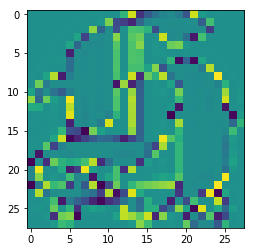

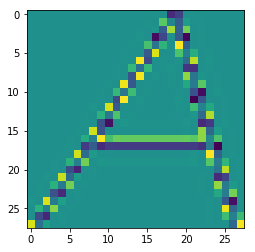

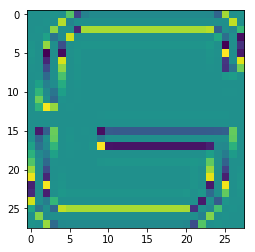

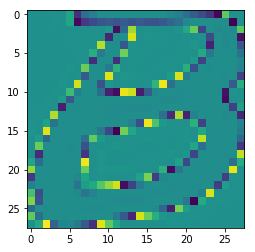

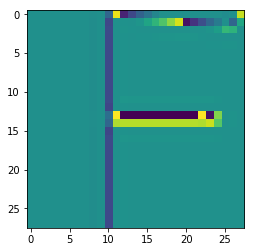

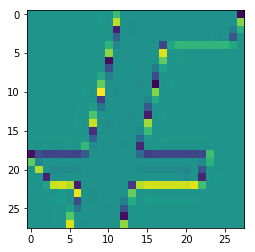

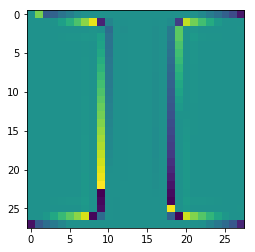

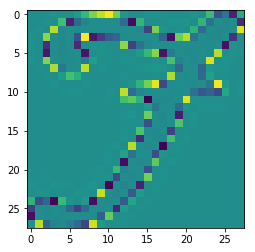

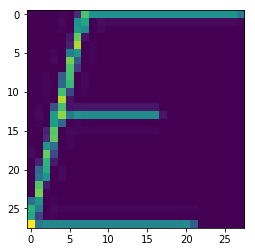

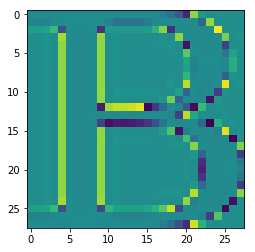

In [50]:
for i in range(10):
    img_mat = train_X[np.random.choice(range(len(train_X)-1))].reshape(image_size, image_size)*128+128
    plt.imshow(img_mat)
    plt.show()

### Creating the model

In [39]:
lr = LogisticRegression(multi_class='multinomial', n_jobs=-1)
cv = GridSearchCV(lr,{
    'C':[i/10 for i in range(5, 106, 10)],
    'solver':['lbfgs','newton-cg','sag','saga']
})
sample_indices = [np.random.choice(range(len(train_X))) for i in range(1000)]
cv.fit(train_X[sample_indices], train_y[sample_indices])

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
id2label = dict(zip(labels_dict.values(), labels_dict.keys()))

Training size: 50
Accuracy:0.14
Predicted:8>I
True:0>A


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


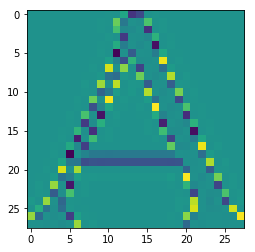

Predicted:8>I
True:4>E


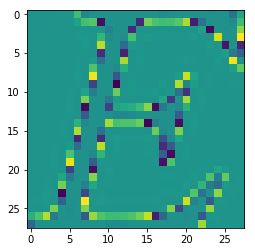

Predicted:7>H
True:2>C


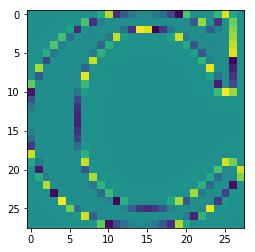

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training size: 100
Accuracy:0.154
Predicted:8>I
True:2>C


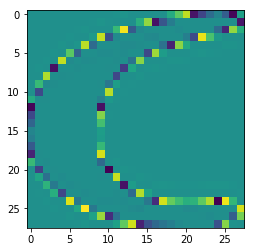

Predicted:7>H
True:4>E


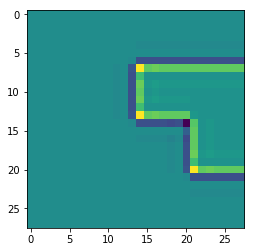

Predicted:7>H
True:7>H


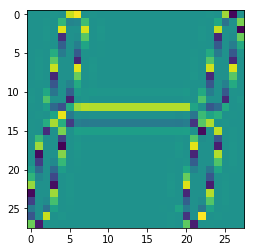

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training size: 1000
Accuracy:0.252
Predicted:9>J
True:7>H


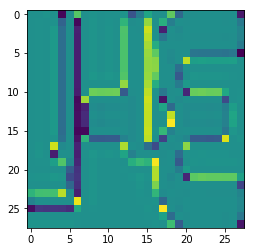

Predicted:7>H
True:0>A


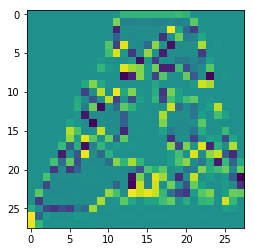

Predicted:5>F
True:0>A


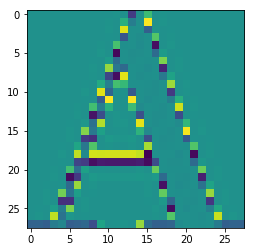

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training size: 5000
Accuracy:0.3
Predicted:8>I
True:8>I


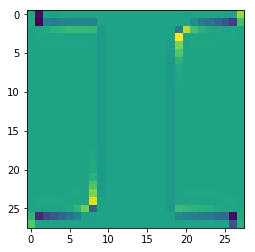

Predicted:5>F
True:1>B


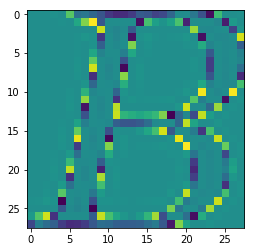

Predicted:0>A
True:2>C


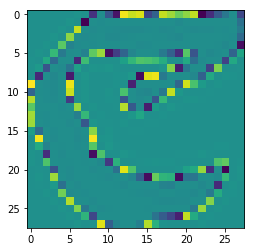

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


{50: 0.14, 100: 0.154, 1000: 0.252, 5000: 0.3}

In [61]:
performance = dict(zip([50,100, 1000, 5000], np.zeros(4)))
test_sample_indices = [np.random.choice(range(len(test_X))) for i in range(1000)]
for size in sorted(performance):
    sample_indices = [np.random.choice(range(len(train_X))) for i in range(size)]
    lr = LogisticRegression(multi_class='multinomial', n_jobs=-1, solver='sag')
    lr.fit(train_X[sample_indices], train_y[sample_indices])
    
    preds = lr.predict(test_X[test_sample_indices])
    accuracy = accuracy_score(test_y[test_sample_indices], preds)
    performance[size] = accuracy
    print("Training size: {0}\nAccuracy:{1}".format(size, accuracy))
    
    for i in range(3):
        idx = np.random.choice(range(len(test_sample_indices)))
        pred = int(preds[idx])
        true = int(test_y[idx])
        print("Predicted:{0}>{1}\nTrue:{2}>{3}".format(pred, id2label[pred],
                                                       true,id2label[true]))
        img_mat = test_X[idx].reshape(image_size, image_size)*128+128
        plt.imshow(img_mat)
        plt.show()
    print("~"*30)
performance